In [ ]:
# 📦 Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# 🧠 Load Data
def load_data():
    files = {
        "/content/epilepsy_with_seizure_data.xlsx": 0,
        "/content/epilepsy_without_seizure_data.xlsx": 1,
        "/content/normal_data.xlsx": 2
    }
    all_data, all_labels = [], []
    for file, label in files.items():
        df = pd.read_excel(file)
        for content in df['Content']:
            signal = np.array([float(x) for x in str(content).split('\n') if x.strip()])
            all_data.append(signal)
            all_labels.append(label)
    return np.array(all_data, dtype=object), np.array(all_labels)

# 🔄 Data Augmentation
def augment_signal(signal):
    noise = np.random.normal(0, 0.01, len(signal))
    jittered = signal + noise
    scaled = signal * np.random.uniform(0.9, 1.1)
    flipped = signal[::-1]
    return [signal, jittered, scaled, flipped]

# 🧹 Preprocess
def preprocess(data, labels):
    max_len = max(len(d) for d in data)
    X_aug, y_aug = [], []
    for signal, label in zip(data, labels):
        for aug in augment_signal(signal):
            padded = np.pad(aug, (0, max_len - len(aug)), 'constant')
            X_aug.append(padded)
            y_aug.append(label)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_aug)
    return np.array(X_scaled), np.array(y_aug), scaler

# 🏗️ 1D CNN Model
def build_1d_cnn(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 5, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(2)(x)
    x = BatchNormalization()(x)

    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2)(x)
    x = BatchNormalization()(x)

    x = Conv1D(256, 3, activation='relu', padding='same')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

# 🚀 Load and preprocess
X_raw, y_raw = load_data()
X_scaled, y_scaled, scaler = preprocess(X_raw, y_raw)
X_scaled = np.expand_dims(X_scaled, axis=-1)  # for Conv1D
y = to_categorical(y_scaled, num_classes=3)

# 🔀 Train/Val/Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, stratify=y_scaled, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=np.argmax(y_temp, axis=1), random_state=42)

# 💾 Optional: Save validation set
np.save("X_val.npy", X_val)
np.save("y_val.npy", y_val)

# ⚖️ Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_scaled), y=y_scaled)
class_weights_dict = dict(enumerate(class_weights))

# 🏗️ Build and Compile Model
model = build_1d_cnn(input_shape=(X_scaled.shape[1], 1), num_classes=3)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# ⏱️ Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)
]

# 🎯 Train
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=32,
                    class_weight=class_weights_dict,
                    callbacks=callbacks)

# ✅ Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")
print(f"🧮 Test Loss: {test_loss:.4f}")

# 💾 Save model
model.save("seizure_detection_1dcnn_model.h5")
print("✅ 1D CNN Model saved!")


Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.6089 - loss: 0.6982 - val_accuracy: 0.5667 - val_loss: 0.8688 - learning_rate: 5.0000e-04
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8399 - loss: 0.4004 - val_accuracy: 0.5467 - val_loss: 0.8246 - learning_rate: 5.0000e-04
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8266 - loss: 0.3867 - val_accuracy: 0.5400 - val_loss: 0.8933 - learning_rate: 5.0000e-04
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8624 - loss: 0.3053 - val_accuracy: 0.5433 - val_loss: 0.9361 - learning_rate: 5.0000e-04
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8915 - loss: 0.2579 - val_accuracy: 0.5200 - val_loss: 1.0050 - learning_rate: 5.0000e-04
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8853 - loss: 0.2966 - val_accuracy: 0.5500 - val_loss: 1.1925 - learning_rate: 5.0000e-04
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8969 - loss: 


✅ Test Accuracy: 0.9833
🧮 Test Loss: 0.0919
✅ 1D CNN Model saved!


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 289ms/step

📊 Classification Report:
              precision    recall  f1-score   support

     Seizure       1.00      0.98      0.99        60
 Non-Seizure       0.99      0.98      0.99       120
      Normal       0.98      1.00      0.99       120

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



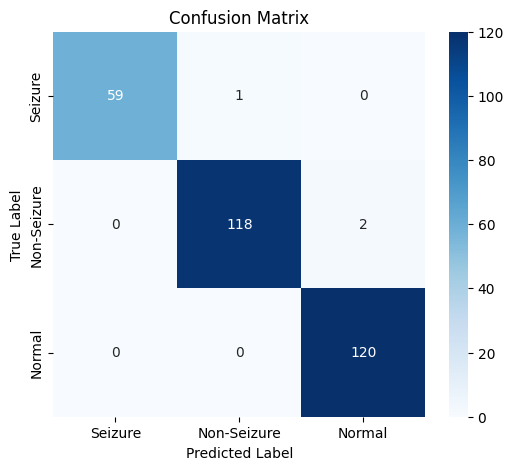

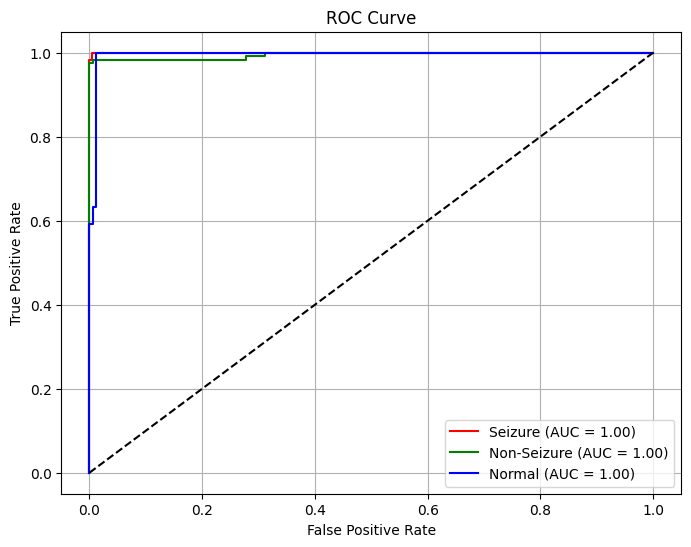

In [ ]:
# 📈 Predict on test set
y_probs = model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# 📊 Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Seizure", "Non-Seizure", "Normal"]))

# 🔄 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Seizure", "Non-Seizure", "Normal"],
            yticklabels=["Seizure", "Non-Seizure", "Normal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 📉 ROC Curve
fpr, tpr, roc_auc = {}, {}, {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['red', 'green', 'blue']
class_names = ["Seizure", "Non-Seizure", "Normal"]
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


✅ Model loaded successfully!
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step

📊 Classification Report:
              precision    recall  f1-score   support

     Seizure       1.00      0.98      0.99        60
 Non-Seizure       0.99      0.98      0.99       120
      Normal       0.98      1.00      0.99       120

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



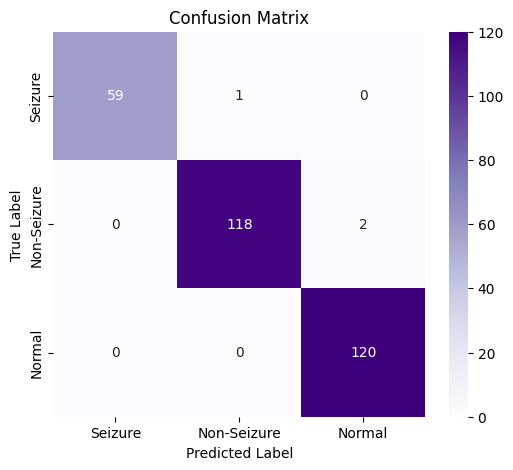

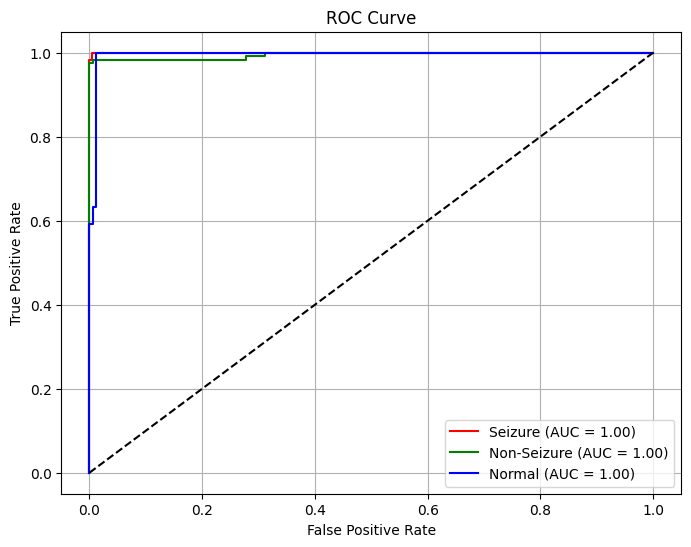


🔍 Number of Misclassified Samples: 3
📌 Example Misclassified Indexes and Labels (up to 10 shown):
Index: 13 | True: Non-Seizure | Predicted: Normal
Index: 31 | True: Non-Seizure | Predicted: Normal
Index: 150 | True: Seizure | Predicted: Non-Seizure


In [ ]:
from tensorflow.keras.models import load_model

# 🔁 Reload model
model = load_model("seizure_detection_1dcnn_model.h5")
print("✅ Model loaded successfully!")

# 🎯 Predict
y_probs = model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# 📊 Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Seizure", "Non-Seizure", "Normal"]))

# 🔄 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Seizure", "Non-Seizure", "Normal"],
            yticklabels=["Seizure", "Non-Seizure", "Normal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 📉 ROC Curve
fpr, tpr, roc_auc = {}, {}, {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['red', 'green', 'blue']
class_names = ["Seizure", "Non-Seizure", "Normal"]
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ❌ Misclassified Samples
misclassified_indices = np.where(y_true != y_pred)[0]
print(f"\n🔍 Number of Misclassified Samples: {len(misclassified_indices)}")
print("📌 Example Misclassified Indexes and Labels (up to 10 shown):")
for i in misclassified_indices[:10]:
    print(f"Index: {i} | True: {class_names[y_true[i]]} | Predicted: {class_names[y_pred[i]]}")


In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

# 📥 Load saved validation input data only
X_val = np.load("X_val_1d.npy")  # Shape: (samples, timesteps, 1)

# ✅ Load trained 1D CNN model
model = load_model("seizure_detection_1dcnn_model.h5")

# 🔮 Predict class probabilities
y_pred_probs = model.predict(X_val)

# 🎯 Convert to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# 📌 Display predicted labels
print("🔮 Predicted Class Labels for X_val:")
print(y_pred)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 336ms/step
🔮 Predicted Class Labels for X_val:
[1 2 2 2 0 2 1 2 2 1 1 2 1 2 0 1 2 2 1 1 2 1 2 1 0 0 0 1 1 2 2 1 2 2 2 0 0
 2 2 2 1 1 2 0 2 1 1 0 2 1 0 1 1 1 2 2 1 2 2 0 1 2 2 1 2 1 1 2 1 0 2 0 1 0
 2 2 2 1 2 2 2 1 0 1 1 1 2 1 1 2 1 2 1 0 1 2 2 2 2 1 1 1 2 2 0 1 2 1 2 2 1
 2 1 2 1 1 1 2 0 1 1 2 2 1 2 2 1 1 0 1 1 1 2 2 1 0 1 2 2 0 1 1 2 2 1 2 2 0
 1 1 0 0 2 1 1 2 2 1 0 0 2 2 1 1 0 0 2 1 1 1 1 2 0 0 1 1 0 1 0 1 2 1 2 0 1
 2 1 0 0 0 1 2 1 1 2 0 0 2 1 1 2 2 1 2 0 1 0 1 0 2 2 1 2 1 2 0 2 1 1 1 1 2
 0 2 0 2 2 2 1 0 2 0 2 2 1 1 0 0 2 2 1 2 0 1 2 1 2 2 2 1 1 1 0 1 2 1 2 0 2
 1 1 2 2 0 1 0 2 2 2 1 1 1 0 0 2 1 1 2 2 2 0 1 2 1 1 1 0 0 2 1 2 1 1 1 2 0
 2 2 1 0]


In [ ]:
import numpy as np

# 📥 Load actual labels for validation data (1D CNN)
y_val = np.load("y_val.npy")  # Shape: (samples, 3) — one-hot encoded

# 🎯 Convert one-hot to class labels
y_true = np.argmax(y_val, axis=1)

# 📌 Display actual class labels
print("✅ Actual Class Labels for y_val (1D CNN):")
print(y_true)


✅ Actual Class Labels for y_val (1D CNN):
[1 2 2 2 0 2 1 2 2 1 1 2 1 2 0 1 2 2 1 1 2 1 2 1 0 0 0 1 1 2 2 1 2 2 2 0 0
 2 2 2 1 1 2 0 2 1 1 0 2 1 0 1 1 1 2 2 1 2 2 0 1 2 2 1 2 1 1 2 1 0 2 0 1 0
 2 1 2 1 2 2 2 1 0 1 1 1 2 2 1 2 1 2 1 0 1 2 2 2 2 1 1 1 2 2 0 2 2 1 2 2 1
 2 1 1 1 1 1 2 0 1 1 2 2 1 2 2 1 1 0 1 1 1 2 2 1 0 1 2 2 0 1 1 2 2 1 2 2 0
 0 1 0 0 2 1 1 2 2 1 0 0 2 2 1 1 0 0 2 1 1 1 1 2 0 0 1 1 0 1 0 1 2 1 2 0 1
 2 1 0 0 0 1 2 1 1 2 0 0 2 1 1 2 2 1 2 0 1 0 1 0 2 2 1 2 1 2 0 2 1 1 2 1 2
 0 2 0 2 2 2 1 0 2 0 2 2 1 1 0 0 2 2 1 2 0 1 2 1 2 2 2 1 1 1 0 1 2 1 2 0 2
 1 1 2 2 0 1 0 2 2 2 2 1 1 0 0 2 1 1 2 2 2 1 1 2 1 1 1 0 0 2 1 2 1 1 1 1 0
 2 2 1 0]


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

# 📥 Load validation data
X_val = np.load("X_val_1d.npy")       # Shape: (samples, time_steps, 1)
y_val = np.load("y_val.npy")          # Shape: (samples, 3) - one-hot encoded

# ✅ Load trained 1D CNN model
model = load_model("seizure_detection_1dcnn_model.h5")

# 🔮 Predict on X_val
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# 🎯 Actual class labels
y_true = np.argmax(y_val, axis=1)

# 🖨️ Display
print("🎯 Actual y_val labels:")
print(y_true)

print("\n🔮 Predicted y_val labels:")
print(y_pred)


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 624ms/step
🎯 Actual y_val labels:
[1 2 2 2 0 2 1 2 2 1 1 2 1 2 0 1 2 2 1 1 2 1 2 1 0 0 0 1 1 2 2 1 2 2 2 0 0
 2 2 2 1 1 2 0 2 1 1 0 2 1 0 1 1 1 2 2 1 2 2 0 1 2 2 1 2 1 1 2 1 0 2 0 1 0
 2 1 2 1 2 2 2 1 0 1 1 1 2 2 1 2 1 2 1 0 1 2 2 2 2 1 1 1 2 2 0 2 2 1 2 2 1
 2 1 1 1 1 1 2 0 1 1 2 2 1 2 2 1 1 0 1 1 1 2 2 1 0 1 2 2 0 1 1 2 2 1 2 2 0
 0 1 0 0 2 1 1 2 2 1 0 0 2 2 1 1 0 0 2 1 1 1 1 2 0 0 1 1 0 1 0 1 2 1 2 0 1
 2 1 0 0 0 1 2 1 1 2 0 0 2 1 1 2 2 1 2 0 1 0 1 0 2 2 1 2 1 2 0 2 1 1 2 1 2
 0 2 0 2 2 2 1 0 2 0 2 2 1 1 0 0 2 2 1 2 0 1 2 1 2 2 2 1 1 1 0 1 2 1 2 0 2
 1 1 2 2 0 1 0 2 2 2 2 1 1 0 0 2 1 1 2 2 2 1 1 2 1 1 1 0 0 2 1 2 1 1 1 1 0
 2 2 1 0]

🔮 Predicted y_val labels:
[1 2 2 2 0 2 1 2 2 1 1 2 1 2 0 1 2 2 1 1 2 1 2 1 0 0 0 1 1 2 2 1 2 2 2 0 0
 2 2 2 1 1 2 0 2 1 1 0 2 1 0 1 1 1 2 2 1 2 2 0 1 2 2 1 2 1 1 2 1 0 2 0 1 0
 2 2 2 1 2 2 2 1 0 1 1 1 2 1 1 2 1 2 1 0 1 2 2 2 2 1 1 1 2 2 0 1 2 1 2 2 1
 2 1 2 1 1 1 2 0 1 1 2 2 1 2 2 1 1 0 1 1 1 2 2 1 0 1 2 2 0 1 1 2 2 1 2 2 0

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step


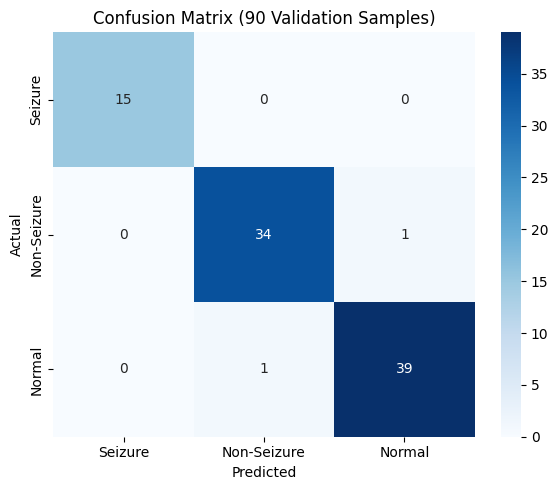

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

# 📥 Load 90-sample validation data
X_val_90 = np.load("X_val_90.npy")
y_val_90 = np.load("y_val_90.npy")

# ✅ Load trained model
model = load_model("seizure_detection_1dcnn_model.h5")

# 🔮 Predict
y_pred_probs_90 = model.predict(X_val_90)
y_pred_90 = np.argmax(y_pred_probs_90, axis=1)
y_true_90 = np.argmax(y_val_90, axis=1)

# 📊 Confusion Matrix
cm_90 = confusion_matrix(y_true_90, y_pred_90)

# 🎨 Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm_90, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Seizure", "Non-Seizure", "Normal"],
            yticklabels=["Seizure", "Non-Seizure", "Normal"])
plt.title("Confusion Matrix (90 Validation Samples)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
